# Impact of atmospheric CO2 concentration on precipitation

Investigating precipitation changes under different global warming scenarios (i.e., different CO2 concentrations). This project is part of the lecture *Climate Variability & Models* at FU Berlin.

**TODO**
- find a paper to get new ideas and check results
    - investigate region in particular? just one season?
- compute some precipitation index
- mask e.g. ocean
- check for certain climate regions (do dry regions become dryer and vice versa?)
- create new moisture regime map (https://storymaps.arcgis.com/stories/61a5d4e9494f46c2b520a984b2398f3b) by computing aridity index
- compute total area of dry / wet regions
- https://en.wikipedia.org/wiki/Evapotranspiration#Potential_evapotranspiration
- https://www.dwd.de/EN/ourservices/gpcc/gpcc.html
- https://www.sciencedirect.com/science/article/pii/S0031018213002320#bb0125 Good paper about which index to choose and why not use something based on evaporation!
- https://www.researchgate.net/profile/Michele-Bernardi/publication/255039317_New_gridded_maps_of_Koeppen's_climate_classification/links/02e7e52ab43b95ff2d000000/New-gridded-maps-of-Koeppens-climate-classification.pdf Warum +10 im richtigen Index!

**NOTES**
- think about units of pre
- which grid cell size?
- removing heading from plots and putting it in bold in caption

In [1]:
# DO NOT FORGET TO ACTIVATE CONDA ENV

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import datetime as dt
import scipy.stats as stats
from scipy.optimize import curve_fit

### figure optimization ###
sns.set_theme()

print(plt.rcParamsDefault["figure.dpi"])
print(plt.rcParamsDefault["figure.figsize"])

%config InlineBackend.figure_format = 'retina'

width = 8.0
plt.rcParams["figure.figsize"] = (width, width * 0.618) # golden ratio
plt.rcParams["figure.dpi"] = 100

100.0
[6.4, 4.8]


## Outline

1. **Climate simulations**: 

    I'm using three PLASIM simulation runs with CO2 concentrations of 610ppm, 790ppm & 1090ppm (numbers taken from [SSPs](#ssps)). The default (*reference*) value is 360ppm. The simulations start in 2000 and last for 30 years.
    

2. **Preprocessing** (using `cdo`-commands):

    - Compute climatology from *daily global* mean temperature for all simulations: Remove 29 Feb. Use final 10 years of simulation and compute 5-day arithmetic mean. Get climatology (i.e., single year of data) and save standard deviation.
    - Similarly for precipitation, however, keeping spatial dimensions (5-day mean or 5-day sum just differ by constant factor $\frac{1}{n}$). Create zonal plot (lat vs time) of absolute values and anomaly (ignoring significance for now).
    - Translate increase of CO2 to global warming: Compute annual mean temperature for last 10 years and average.
    - Again, similarly for precipitation: Compute annual *sum* of precipitation -> average to get single mean "equilibrium" state -> subtract *reference* to get anomaly map (a neat way to determine significant derivations between *reference* and *ssps* is [Welch's *t*-test](https://www.geo.fu-berlin.de/en/v/soga/Basics-of-statistics/Hypothesis-Tests/Hypothesis-Tests-for-Two-Population-Means/Standard-Deviations-Not-Assumed-Equal/index.html); indicate significance with black dots)
    
    (Note: Since $\overline{x_i} - \overline{y_i} = \overline{x_i - y_i}$, it doesn't matter in which order anomaly and average are computed.)
    
    
3. **Analysis** in this notebook:

    - Plot *shared socioecomonic pathways*.
    - Visualize temperature climatology.
    - Translate CO2 concentration into global warming and identify linear (?) trend.
    - Precipitation climatology.
    - Zonal plot to investigate temporal evolution of "equilibrium" precipitation state.
    - Plot map of mean precipitation anomaly (with significance "marks").
    - Aridity index & precipitation regime map.
    

## <a name="ssps"></a> Shared Socioeconomic Pathways

The atmospheric CO2 concentration can be derived from these projected socioeconomic pathways, I use the preprocessed data from [ourworldindata](https://ourworldindata.org/explorers/ipcc-scenarios?facet=none&Metric=Greenhouse+gas+concentrations&Sub-metric=Carbon+dioxide+%28CO%E2%82%82%29&Rate=Per+capita&Region=Global&country=SSP1+-+Baseline~SSP2+-+Baseline~SSP3+-+Baseline~SSP4+-+Baseline~SSP5+-+Baseline).

In [2]:
ssps = pd.read_csv("../data/ipcc-scenarios.csv", usecols=["Scenario", "Year", "CO2 concentration"])
ssps["Scenario"].unique()
ssps

,Scenario,Year,CO2 concentration
0,SSP1 - 1.9,2005,379.85000
1,SSP1 - 1.9,2010,390.50530
2,SSP1 - 1.9,2020,412.14202
3,SSP1 - 1.9,2030,424.68152
4,SSP1 - 1.9,2040,425.52721
...,...,...,...
281,SSP5 - Baseline,2060,635.79256
282,SSP5 - Baseline,2070,730.02550
283,SSP5 - Baseline,2080,841.52016
284,SSP5 - Baseline,2090,963.84157


**Note**: Scenarios with "*scenario* - *float*" represent projected socioeconomic pathways which lead to *float* value of radiative forcing.

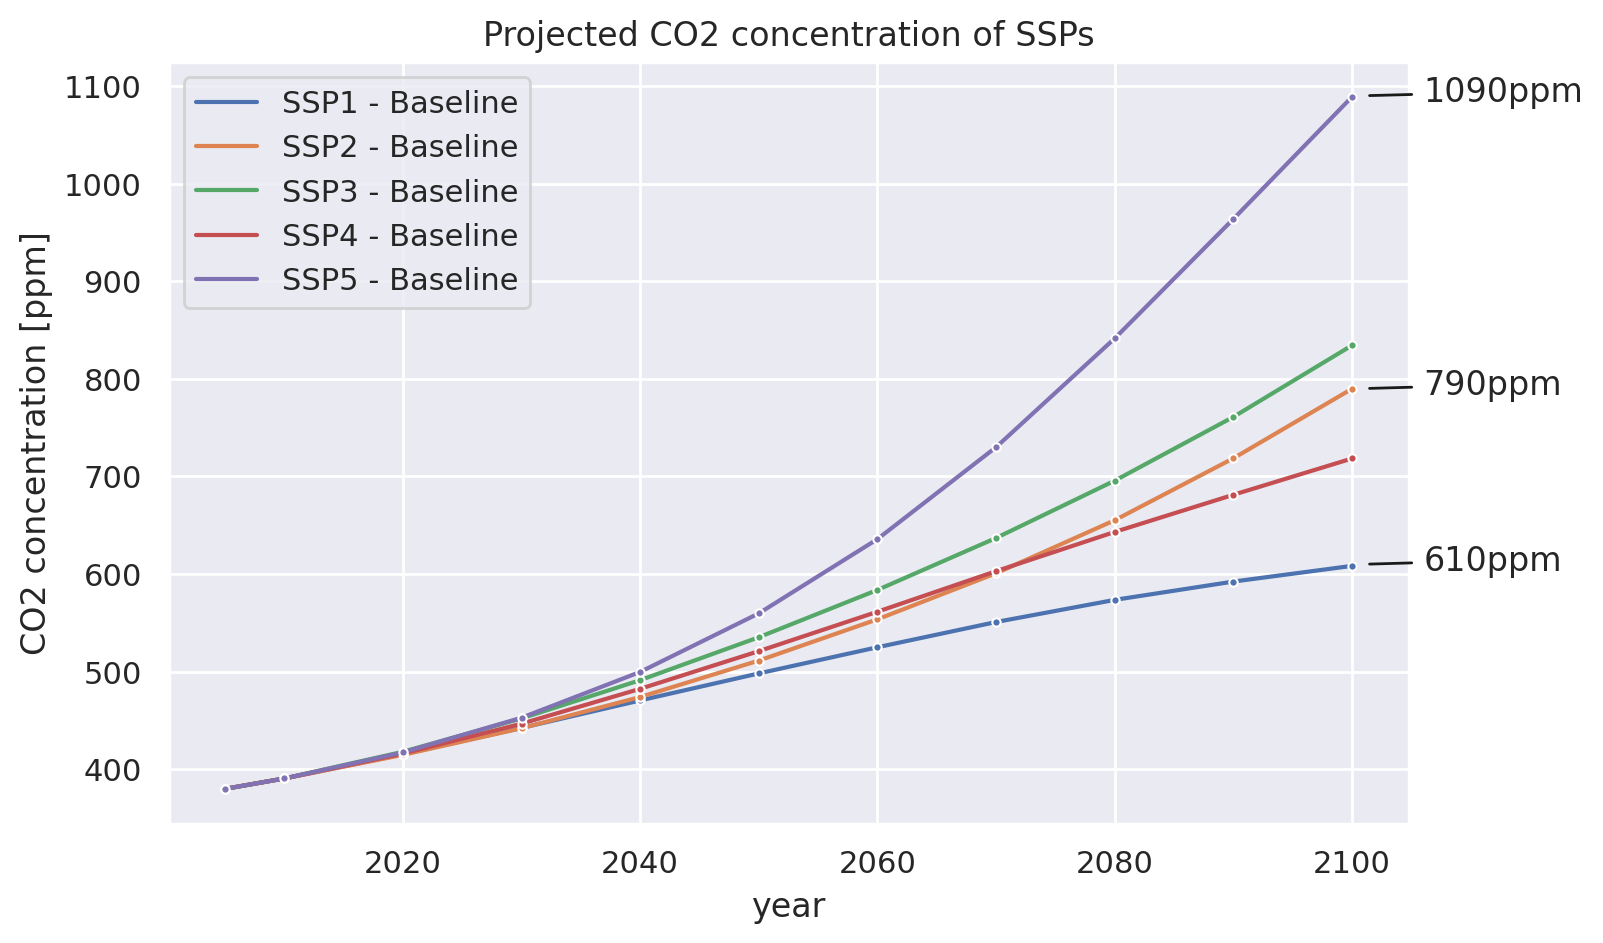

In [3]:
patternKeep = "Baseline"
filter = ssps["Scenario"].str.contains(patternKeep)
data = ssps[filter]

fig, ax = plt.subplots()
sns.lineplot(data=data, x="Year", y="CO2 concentration", hue="Scenario", marker=".", ax=ax)
ax.set_ylabel("CO2 concentration [ppm]")
ax.set_xlabel("year")
ax.set_title("Projected CO2 concentration of SSPs")
ax.legend(title=None)

for c in [610, 790, 1090]:
    ax.annotate(str(c)+"ppm", xy=(2101, c), xytext=(2106, c-6), arrowprops=dict(arrowstyle="-", color="k"))

fig.savefig("../figs/ssps-pathways.png", dpi=300, bbox_inches="tight")

## Climatology of `t2m`

In [4]:
# create datetime object from time values
def as_datetime(tlist):
    tt = []
    for t in tlist:
        tt.append(dt.date(1, 1, 1) + dt.timedelta(days=t))
    return tt

# rename reference simulation
def change_key(d):
    d["reference"] = d["plasim_ref_ln"]
    del d["plasim_ref_ln"]

Import climatology of surface temperature:

In [5]:
sims = ["plasim_ref_ln", "SSP1", "SSP3", "SSP5"]

t2m = {}
t2m_std = {}
time = {}

# get temperature values
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim.nc")
    time[sce] = as_datetime(f.variables["time"][:])
    # somehow, temperature has shape (73, 1, 1)
    t2m[sce] = f.variables["t2m"][:].flatten()
    f.close()

# get standard devation
for sce in sims:
    f = Dataset(f"../data/{sce}-tmp-clim-std.nc")
    t2m_std[sce] = f.variables["t2m"][:].flatten()
    f.close()
  
change_key(t2m)
change_key(t2m_std)
change_key(time)

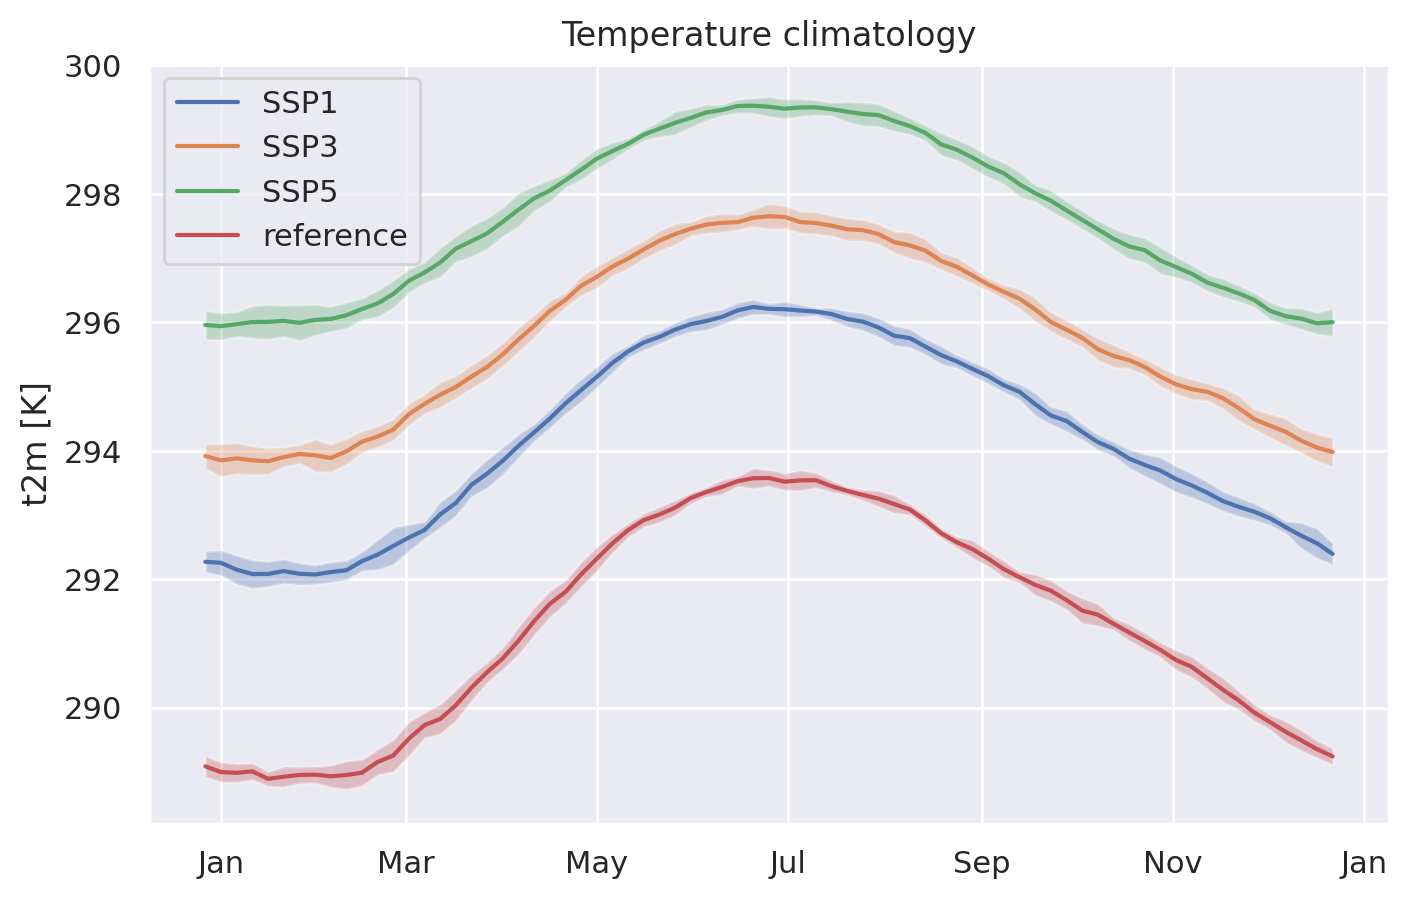

In [6]:
dt_fmt = mdates.DateFormatter('%b')

fig, ax = plt.subplots()
for sce in list(t2m.keys()):
    ax.plot(time[sce], t2m[sce], label=sce)
    ax.fill_between(time[sce], t2m[sce]-t2m_std[sce], t2m[sce]+t2m_std[sce], alpha=.3)
ax.xaxis.set_major_formatter(dt_fmt)
ax.legend()
ax.set_ylabel("t2m [K]")
ax.set_title("Temperature climatology");

## Global warming for each scenario

Import global *annual* (hence, variables are labelled with `_an`-suffix) mean surface temperature:

In [7]:
co2 = np.array([360.0, 610.0, 790.0, 1090.0]) # co2 concentration in ppm (same order as simulation names!)

t2m_an = {}
t2m_an_std = {}

# get temperature values
for cc, sce in zip(co2, sims):
    f = Dataset(f"../data/{sce}-tmp-annual.nc")
    # temperature (still) has shape (1, 1, 1)
    t2m_an[cc] = f.variables["t2m"][0,0,0]
    f.close()

# get standard devation
for cc, sce in zip(co2, sims):
    f = Dataset(f"../data/{sce}-tmp-annual-std.nc")
    t2m_an_std[cc] = f.variables["t2m"][0,0,0]
    f.close()

In [8]:
# linear fit
def linear(x, a, b):
    return a * x + b

xdata = co2
ydata = list(t2m_an.values())
yerr = list(t2m_an_std.values())

popt, pcov = curve_fit(linear, xdata, ydata, sigma=yerr)
perr = np.sqrt(np.diag(pcov))

In [9]:
# compute slope of temperature increase
print("slope:")
print(f"{np.round(popt[0], 4)} +/- {np.round(perr[0], 4)}")

# compute temperature increase ("global warming") per scenario
t2m_increase = []
t2m_increase_std = []

for c in [610.0, 790.0, 1090.0]:
    t2m_increase.append(
        t2m_an[c] - t2m_an[360.0]
    ) 
    t2m_increase_std.append(
        # error propagation (sqrt(std1**2 + std2**2))
        np.sqrt(t2m_an_std[360.0]**2 + t2m_an_std[c]**2)
    )

slope:
0.0098 +/- 0.0011


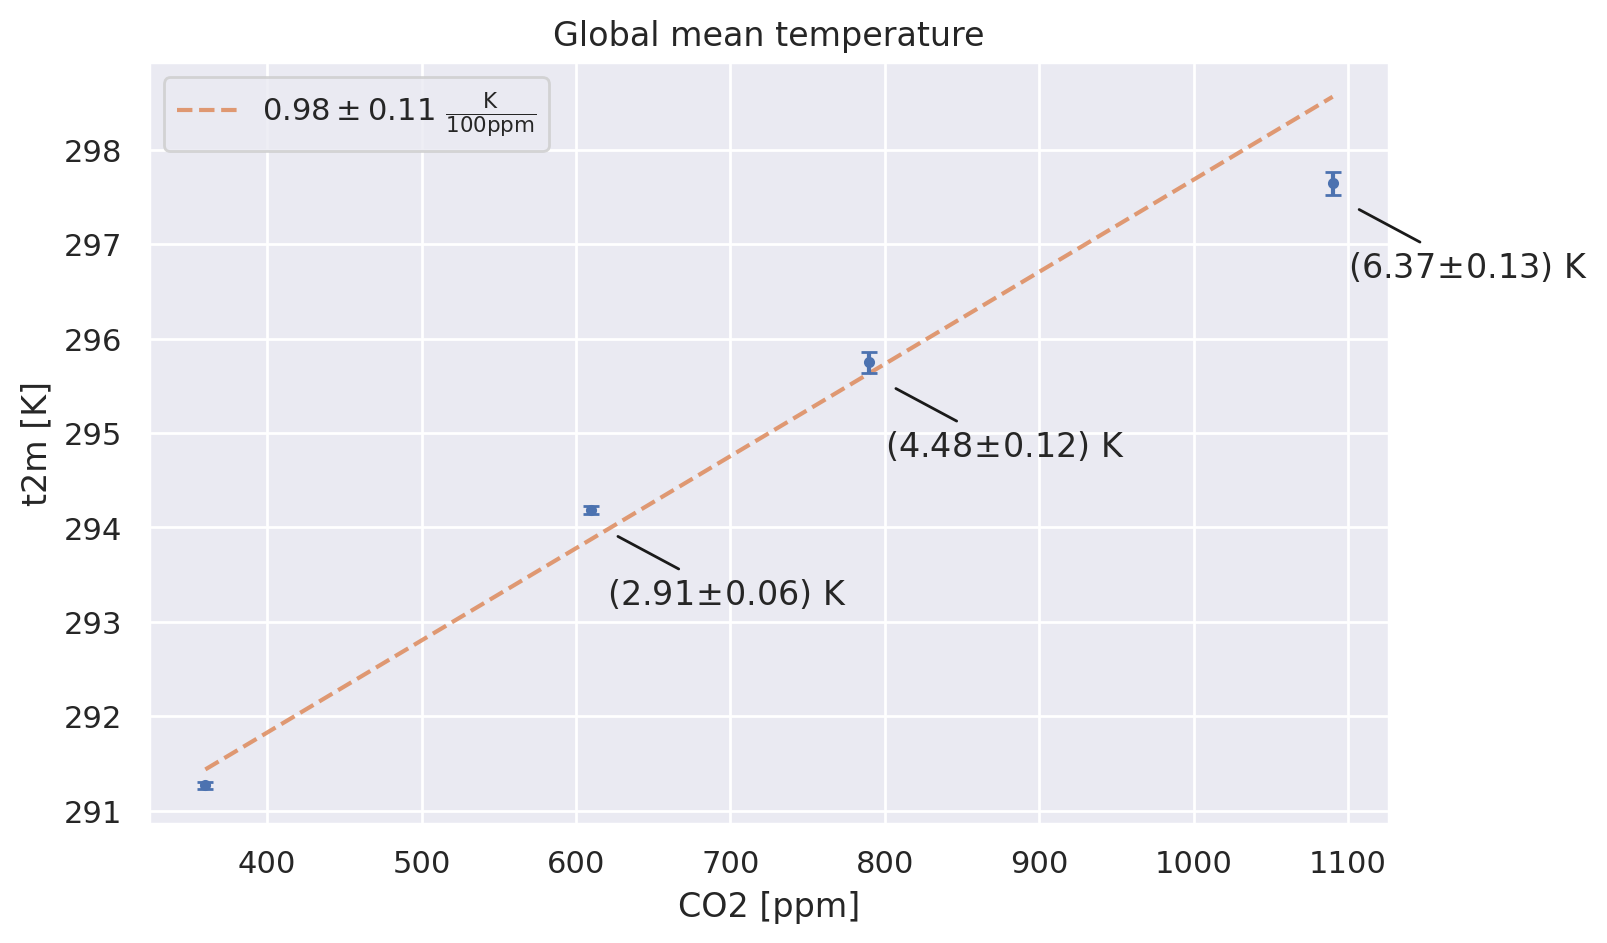

In [10]:
# plotting
fig, ax = plt.subplots()
ax.errorbar(xdata, ydata, yerr = yerr, ls="None", marker=".", capsize=3)
ax.plot(xdata, linear(xdata, *popt), ls="--", alpha=0.8, zorder=1,
        label=r"$0.98 \pm 0.11 \ \rm\frac{K}{100 ppm}$")
ax.legend()
ax.set_ylabel("t2m [K]")
ax.set_xlabel("CO2 [ppm]")
ax.set_title("Global mean temperature")

# add (global mean) temperature increase
for i, c in enumerate([610.0, 790.0, 1090.0]):
    ax.annotate("(" + str(np.round(t2m_increase[i], 2)) + r"$\! \pm\! $" + str(np.round(t2m_increase_std[i], 2)) + ") K",
                xy=(c+14, t2m_an[c]-0.25), xytext=(c+10, t2m_an[c]-1),
                arrowprops=dict(arrowstyle="-", color="k"))

# TODO: compare with literature values

## Climatology of `pr`

The model outputs *daily* values of precipitation in units of $\rm\frac{m}{s}$, hence, multiplying by $3600 \cdot 24 \cdot 1000 = 864 \cdot 10^5$ yields units of $\rm\frac{mm}{day}$. **Quick reminder**: The climatologies are based 1) on the last ten years of the simulation and 2) on 5-day multi-year means. 

**Note**: In the pre-processing step I didn't use the global mean (`_gmean`) values in order to preserve the spatial dimension.

In [11]:
pr = {}
pr_std = {}

# get precipitation values
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim.nc")
    pr[sce] = f.variables["pr"][:] * 864e5
    
# get standard deviation
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-clim-std.nc")
    pr_std[sce] = f.variables["pr"][:] * 864e5

change_key(pr)
change_key(pr_std)
    
lon = f.variables["lon"][:]
lat = f.variables["lat"][:]
time = as_datetime(f.variables["time"][:])

f.close()

### Global mean

In [12]:
def gm(data, lat):
    # zonal mean
    data_zm = np.mean(data, axis=2)
    # meridional mean
    w = np.cos(np.deg2rad(lat))
    data_gm = np.average(data_zm, weights=w, axis=1)
    return data_gm

pr_gm = {}
pr_std_gm = {}

for sce in list(pr.keys()):
    pr_gm[sce] = gm(pr[sce], lat)
    pr_std_gm[sce] = gm(pr_std[sce], lat)

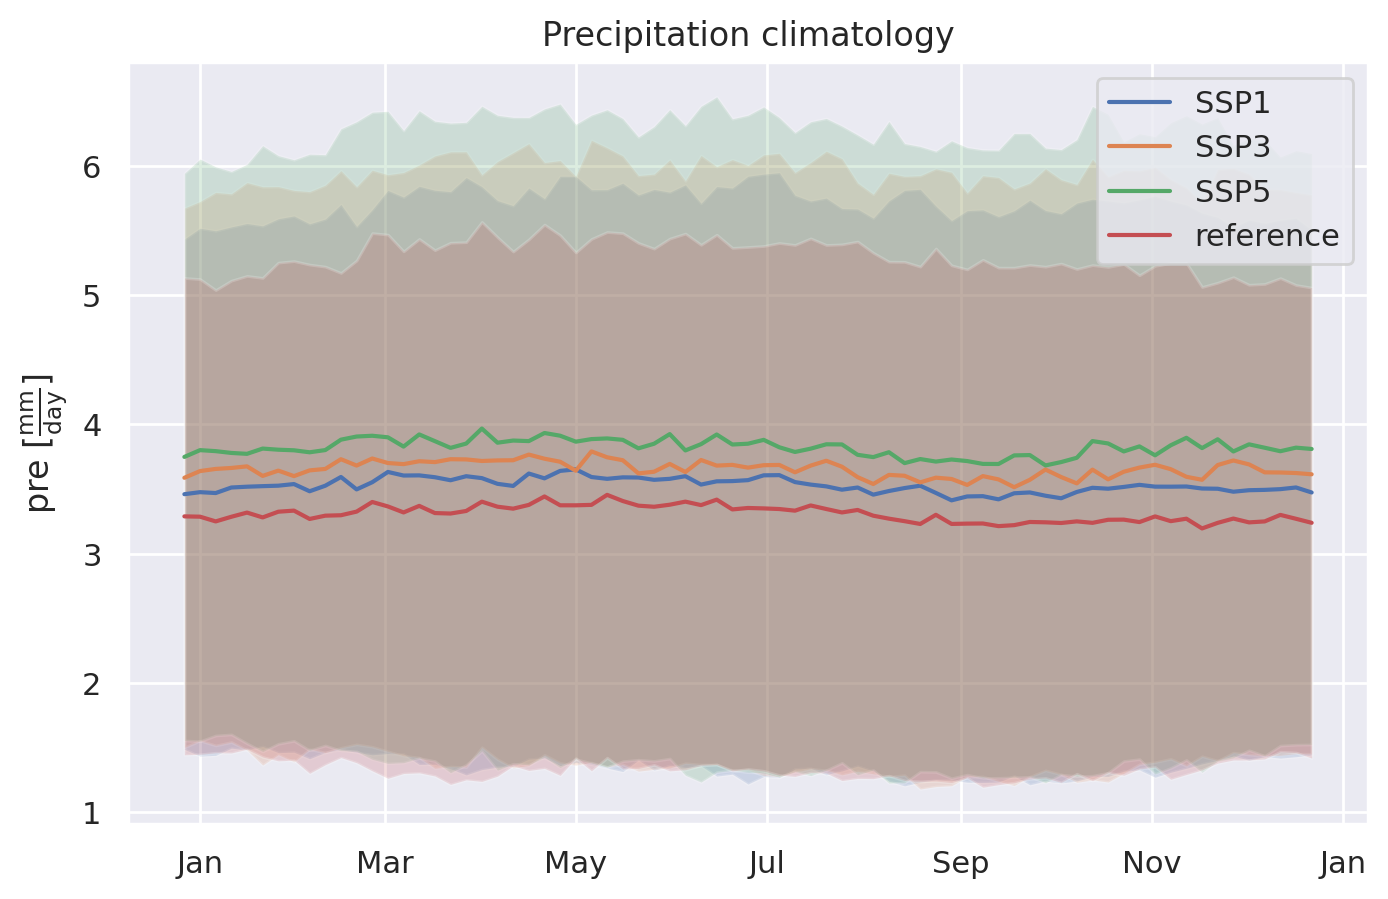

In [13]:
fig, ax = plt.subplots()
for sce in list(pr_gm.keys()):
    ax.plot(time, pr_gm[sce], label=sce)
    ax.fill_between(time, pr_gm[sce]-pr_std_gm[sce], pr_gm[sce]+pr_std_gm[sce], alpha=.2)
ax.xaxis.set_major_formatter(dt_fmt)
ax.legend()
ax.set_ylabel(r"pre [$\rm\frac{mm}{day}$]")
ax.set_title("Precipitation climatology");

### Zonal mean

In [14]:
# zonal mean
pr_zm = {}

for sce in list(pr.keys()):
    pr_zm[sce] = np.mean(pr[sce], axis=2)
    
np.shape(pr_zm[sims[1]])

(73, 32)

In [15]:
xtime, ylat = np.meshgrid(time, lat)
np.shape(xtime)

(32, 73)

It's important to note that the range of colors for each subplot *doesn't* differ, otherwise, `vmin` & `vmax` have to be set to the min and max value of *all* data (following this [hint](https://stackoverflow.com/questions/67165630/one-colorbar-to-indicate-data-range-for-multiple-subplots-using-matplotlib) on stackoverflow).

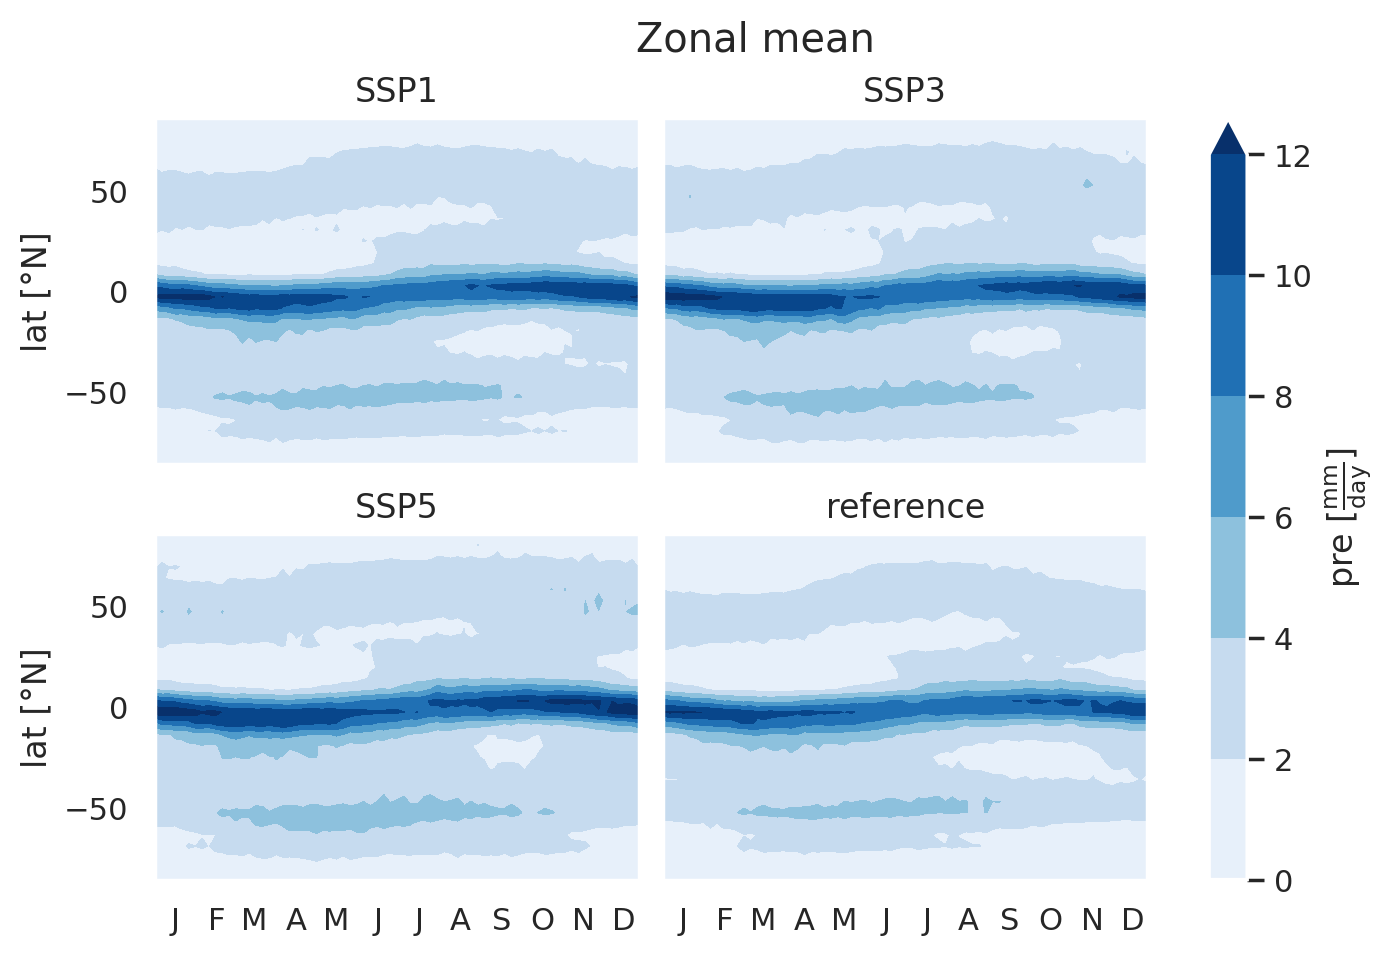

In [16]:
# use somewhat hard-coded format of displaying first letter of monthy only
def first_letter_only(ax):
    pos = ax.get_xticks()
    # moving letters to the right (+ 10 days) -> looks nicer
    ax.set_xticks(pos+10, labels=['J','F','M','A','M','J','J','A','S','O','N','D'])

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.05))
axs = axs.flatten()

for i, sce in enumerate(list(pr.keys())):
    cf = axs[i].contourf(xtime, ylat, np.transpose(pr_zm[sce]), cmap="Blues", extend="max")
    axs[i].set_title(str(sce))
    

cb = fig.colorbar(cf, ax=axs.tolist(), )
cb.set_label(r"pre [$\rm\frac{mm}{day}$]")

axs[0].set_ylabel("lat [°N]")
axs[2].set_ylabel("lat [°N]")

fig.suptitle("Zonal mean")
first_letter_only(axs[0])

# TODO: adding grid to subplots doesn't seem to work...
#       something to do with seaborn defaults: grid is behind data

Alternatively, in order to get a single colorbar that matches the data of every subplot, one can define a grid by using [matplotlib's `ImageGrid`](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.axes_grid1.axes_grid.ImageGrid.html). However, I do not know how to proceed with the `grid`-object, e.g., no idea how to label the axes.

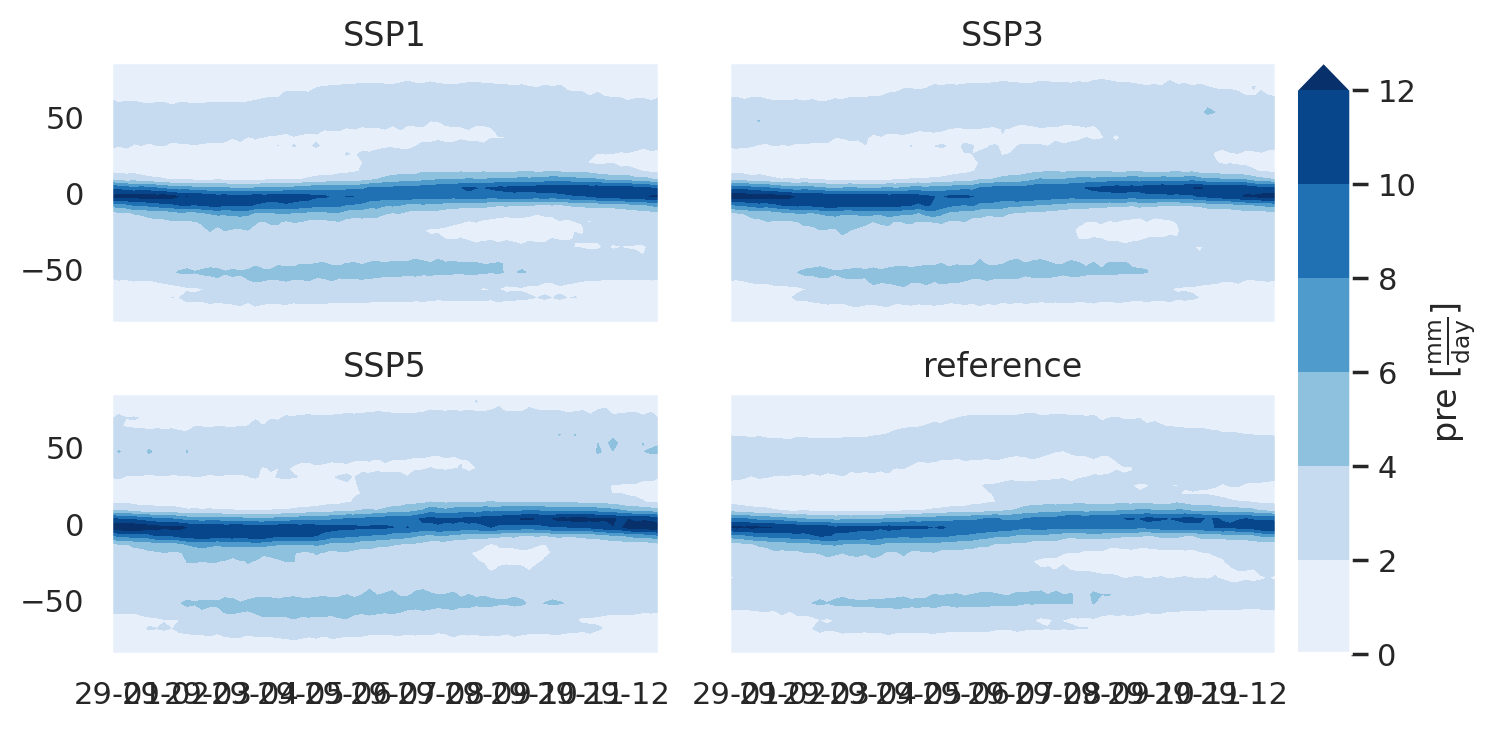

In [17]:
from mpl_toolkits.axes_grid1 import ImageGrid

fig = plt.figure()

grid = ImageGrid(fig=fig, rect=111, nrows_ncols=(2, 2), share_all=True,
                 axes_pad=0.35, cbar_mode="single", cbar_pad=0.1)

for ax, sce in zip(grid, list(pr.keys())):
    cf = ax.contourf(xtime, ylat, np.transpose(pr_zm[sce]), cmap="Blues", extend="max")
    ax.set_title(str(sce))

cb = ax.cax.colorbar(cf)
cb.set_label(r"pre [$\rm\frac{mm}{day}$]")

### Anomaly of zonal mean

In [18]:
# compute anomaly
pr_zm_anom = {}

for sce in list(pr_zm.keys()):
    anom = pr_zm[sce] - pr_zm["reference"]
    # mask values +/- 5% of highest value
    pr_zm_anom[sce] = np.ma.masked_where(np.absolute(anom) < 0.05 * 2.789, anom)

In [19]:
# meaningful colormap
v = np.max(np.absolute(pr_zm_anom["SSP5"]))
v

2.7893457

When visualizing anomlies, values close to 0 aren't of much concern, hence, I want to display them as white using the `set_bad` property of matplotlib. It determines the colour of masked values.

In [20]:
cmap = mpl.cm.get_cmap("seismic_r").copy()
cmap.set_bad(color="white")

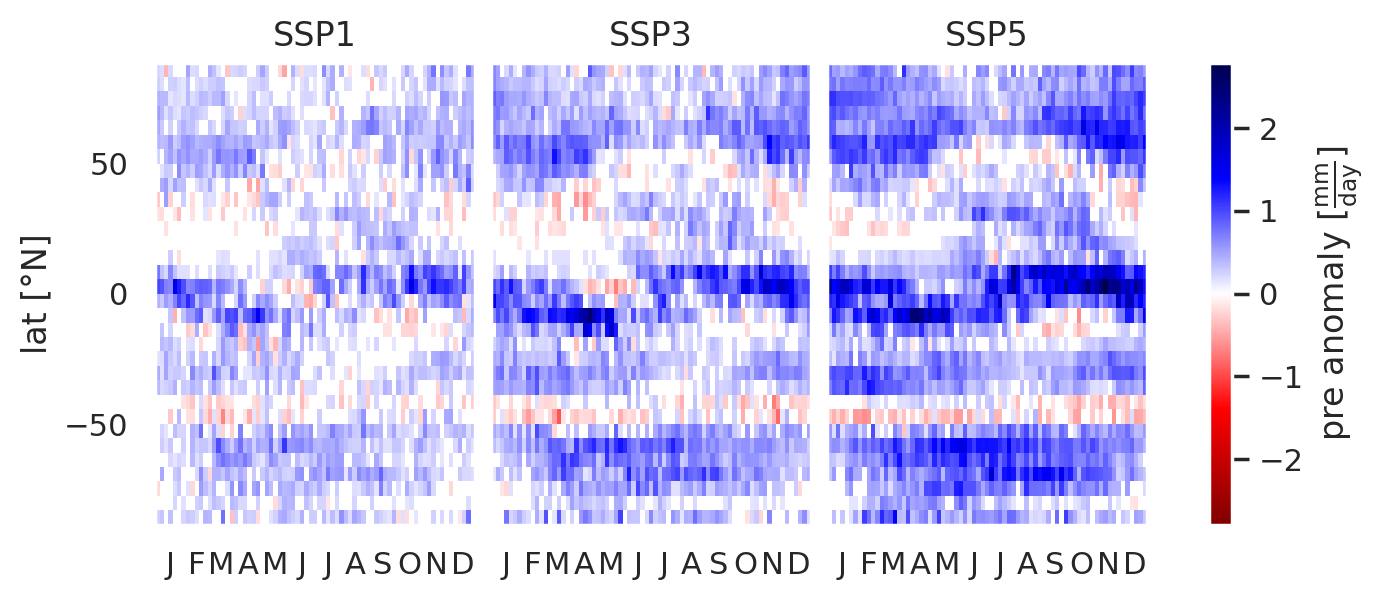

In [21]:
# use somewhat hard-coded format of displaying first letter of monthy only
# pcolormesh sets different number of x-ticks than contourf
def first_letter_only_mesh(ax):
    # year of data is 0029
    pos = [dt.date(29, m, 10) for m in range(1,12+1)]
    ax.set_xticks(pos, labels=['J','F','M','A','M','J','J','A','S','O','N','D'])

ssps = ["SSP1", "SSP3", "SSP5"]

fig, axs = plt.subplots(1, 3, figsize=(width, 3.0), sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.05))
axs = axs.flatten()

for i, sce in enumerate(ssps):
    cf = axs[i].pcolormesh(xtime, ylat, np.transpose(pr_zm_anom[sce]), cmap=cmap, vmin=-v, vmax=v)
    axs[i].set_title(str(sce))
    
cb = fig.colorbar(cf, ax=axs.tolist(), )
cb.set_label(r"pre anomaly [$\rm\frac{mm}{day}$]")

axs[0].set_ylabel("lat [°N]")
first_letter_only_mesh(axs[0]) # setting sharex=True changes all x-axes at once

Alternatively, the maps can be produced using `contourf`. Here, the `set_bad` property of the colormap is ignored. A quite nice solution is to change the color of the plot window to white (as masked values are omitted from plotting anyways).

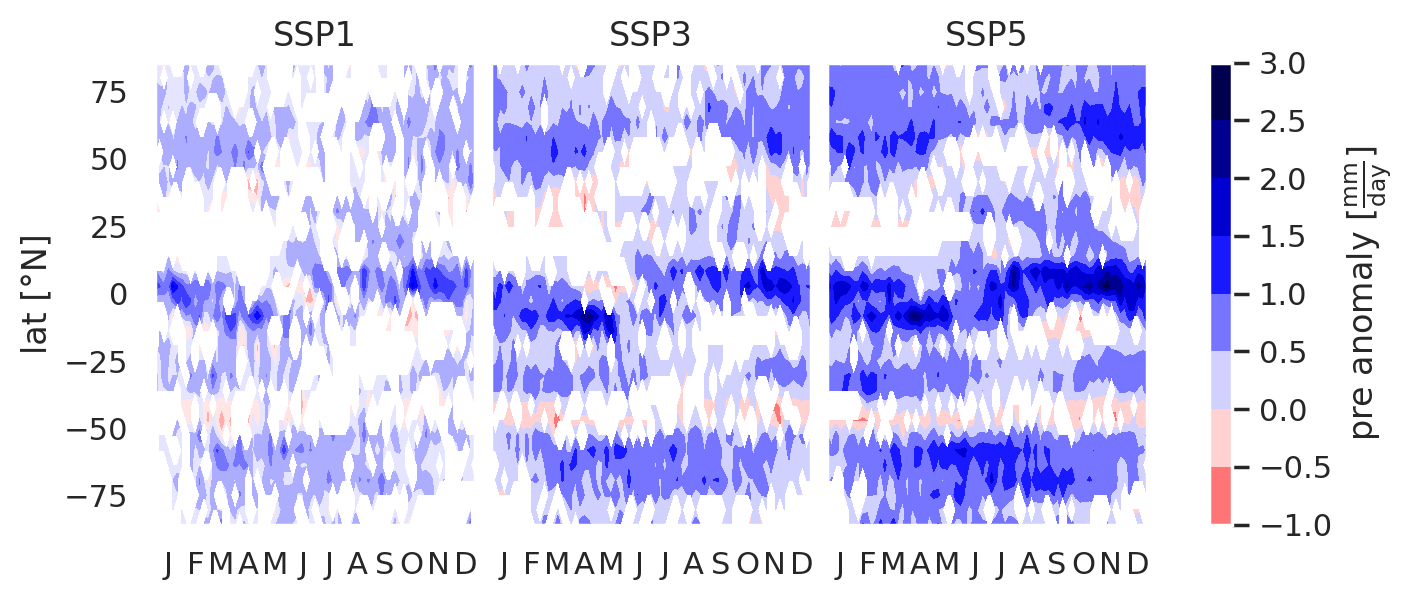

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(width, 3.0), sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.05))
axs = axs.flatten()

for i, sce in enumerate(ssps):
    cf = axs[i].contourf(xtime, ylat, np.transpose(pr_zm_anom[sce]), cmap="seismic_r", vmin=-v, vmax=v)
    axs[i].set_title(str(sce))
    axs[i].set_facecolor("white")
    
cb = fig.colorbar(cf, ax=axs.tolist(), )
cb.set_label(r"pre anomaly [$\rm\frac{mm}{day}$]")

axs[0].set_ylabel("lat [°N]")
first_letter_only(axs[0]) # setting sharex=True changes all x-axes at once

## Anomaly map of `pr`

**Reminder**: The cdo-commands of pre-processing the data: `-yearsum -del29feb -selyear,20/29 input.nc output.nc`. Convert units from $\rm\frac{m}{s}$ to $\rm\frac{m}{yr}$ by multiplying with $3600 \cdot 24 = 86400$ (sum of daily values converts day to year automatically).

In [23]:
pr_an = {}

# get precipitation values
for sce in sims:
    f = Dataset(f"../data/{sce}-pre-annual.nc")
    pr_an[sce] = f.variables["pr"][:] * 864e2
    
change_key(pr_an)

lon = f.variables["lon"][:]
lat = f.variables["lat"][:]

f.close()

np.shape(pr_an["reference"]) # (still) ten time steps!

(10, 32, 64)

In [24]:
# time mean
pr_an_tm = {}

for sce in list(pr_an.keys()):
    pr_an_tm[sce] = np.mean(pr_an[sce], axis=0)
    
print(np.shape(pr_an_tm["reference"]))

# anomaly of time mean
pr_an_tm_anom = {}
pr_an_tm_anom_msk = {}

for sce in ssps:
    anom = pr_an_tm[sce] - pr_an_tm["reference"]
    anom_msk = np.ma.masked_where(np.absolute(anom) < 0.05 * 2.013, anom)
    pr_an_tm_anom_msk[sce], llon = add_cyclic_point(anom_msk, coord=lon)
    pr_an_tm_anom[sce], _ = add_cyclic_point(anom, coord=lon)

(32, 64)


In [25]:
# get value of largest anomaly
v = np.max(np.absolute(pr_an_tm_anom["SSP5"]))
v

2.012782

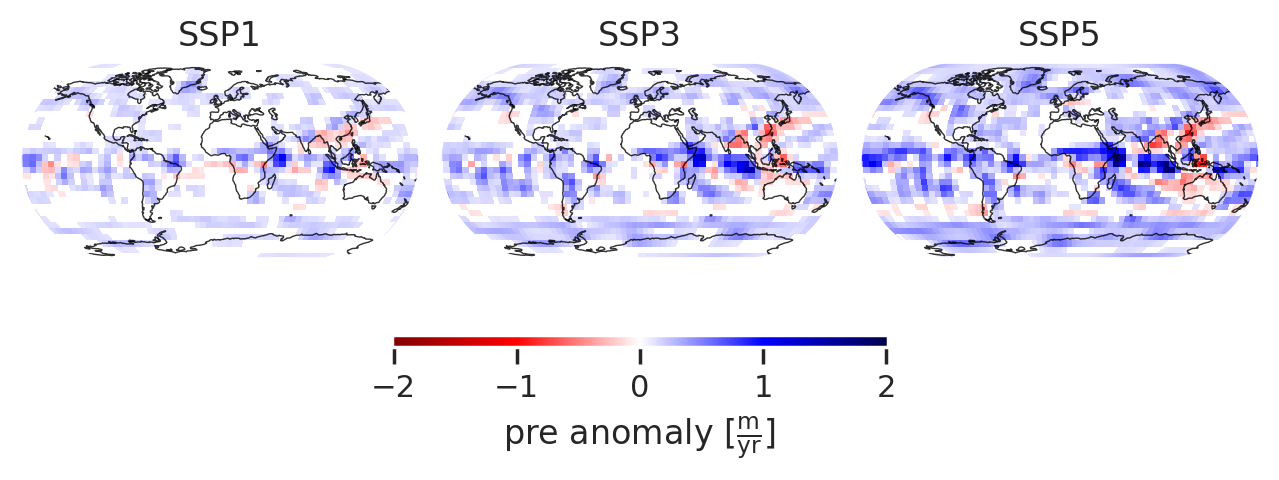

In [26]:
trans = ccrs.PlateCarree()
proj = ccrs.EckertIII()

xllon, yllat = np.meshgrid(llon, lat)

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.05), subplot_kw=dict(projection = proj))
axs = axs.flatten()

for i, sce in enumerate(ssps):
    cf = axs[i].pcolormesh(xllon, yllat, pr_an_tm_anom_msk[sce], transform=trans, shading="nearest", cmap="seismic_r", vmin=-v, vmax=v)
    axs[i].set_title(str(sce))
    axs[i].coastlines(lw=0.5, alpha=0.8)
    axs[i].set_facecolor("white")
     
cb = fig.colorbar(cf, ax=axs.tolist(), orientation="horizontal", shrink=0.4, aspect=40, pad=0.1)
cb.set_label(r"pre anomaly [$\rm\frac{m}{yr}$]");

### Welch's $t$-test

Test for the null hypothesis that two *independent* samples have identical average (expected) values. Alternative hypothesis ($H_1$) is defined as means of distributions underlying the samples are unequal (`two-sided`).

From [scipy-docs](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html): *A p-value larger than a chosen threshold (here, 1%) indicates that our observation is not so unlikely to have occurred by chance. Therefore, we do not reject the null hypothesis of equal population means. If the p-value is smaller than our threshold, then we have evidence against the null hypothesis of equal population means.*

In [27]:
pthresh = 0.01

signi = {}
ref_pr = pr_an["reference"]

# all pathways
for sce in ssps:
    sce_pr = pr_an[sce]
    pvals = np.zeros((32, 64))
    
    # all grid cells
    for ila, _ in enumerate(lat):
        for ilo, _ in enumerate(lon):
            tt = stats.ttest_ind(sce_pr[:, ila, ilo], ref_pr[:, ila, ilo], alternative="two-sided", equal_var=False)
            pvals[ila, ilo] = tt.pvalue
    
    # set 1 if pval < threshold, otherwise nan
    signi[sce] = np.where(pvals < pthresh, 1, np.nan)

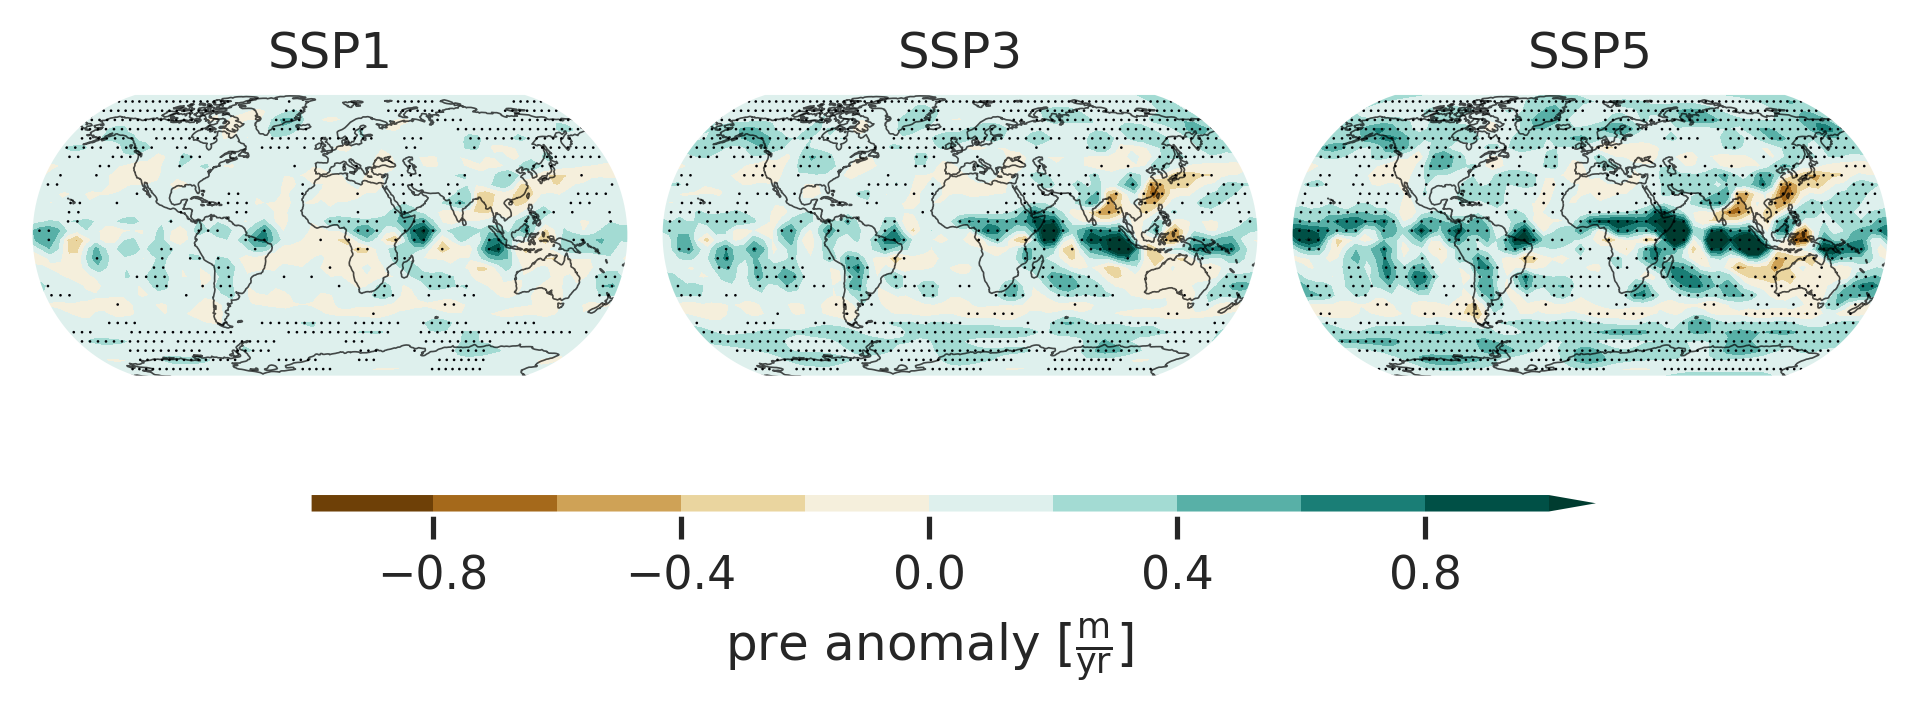

In [28]:
# "ylat" already defined in zonal plots
xlon, ylat = np.meshgrid(lon, lat)

proj = ccrs.EckertIII()

fig, axs = plt.subplots(1, 3, dpi=150, sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.05), subplot_kw=dict(projection = proj))
axs = axs.flatten()

for i, sce in enumerate(ssps):
    cf = axs[i].contourf(xllon, yllat, pr_an_tm_anom[sce], transform=trans, cmap="BrBG", levels=np.linspace(-1.0, 1.0, 11), extend="max")
    # alternatively: cmap="seismic_r", vmin=-2.5, vmax=2.5, levels=n
    axs[i].scatter(xlon, ylat, transform=trans, c=signi[sce], cmap="inferno", s=0.4, lw=0)
    axs[i].set_title(str(sce))
    axs[i].coastlines(lw=0.4, alpha=0.7)
    axs[i].set_facecolor("white")
     
cb = fig.colorbar(cf, ax=axs.tolist(), orientation="horizontal", shrink=0.7, aspect=60, pad=0.1)
cb.set_label(r"pre anomaly [$\rm\frac{m}{yr}$]");

**Note**: When comparing to [literature](https://www.ipcc.ch/report/ar6/wg1/figures/summary-for-policymakers/figure-spm-5), keep in mind that I'm just altering the atmospheric CO2 concentration and my reference is (already) at 360ppm. 

## Annual `pr` sum

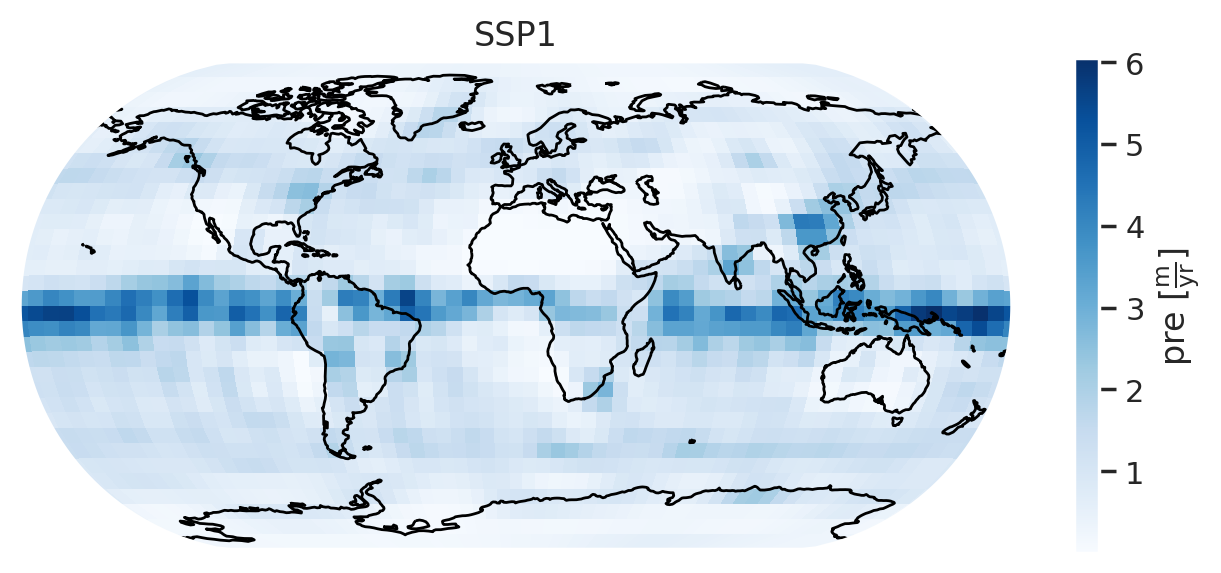

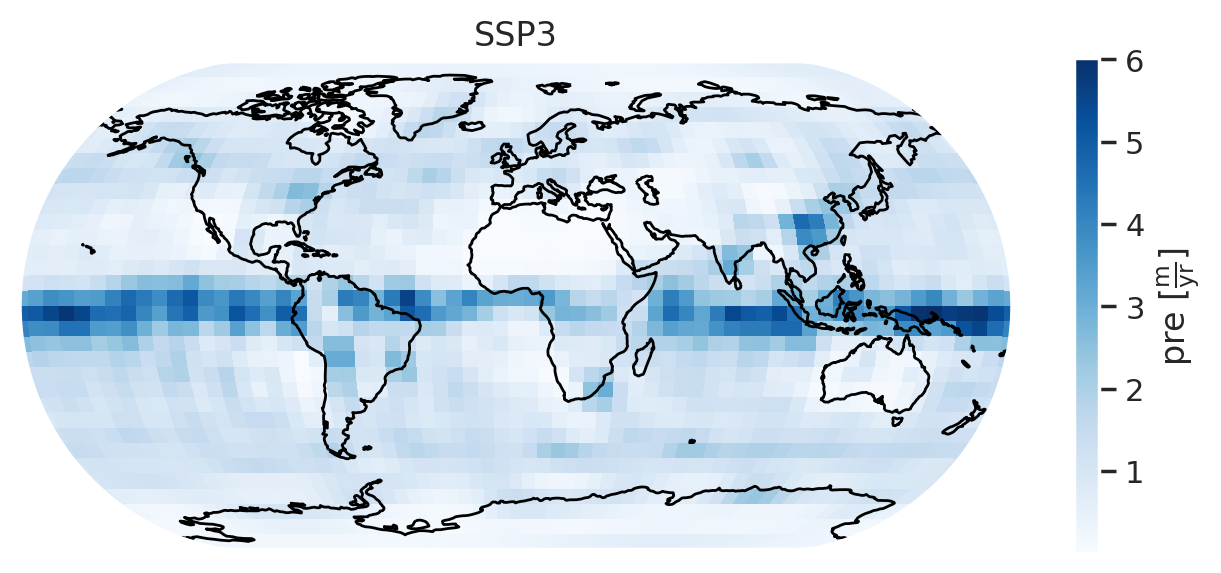

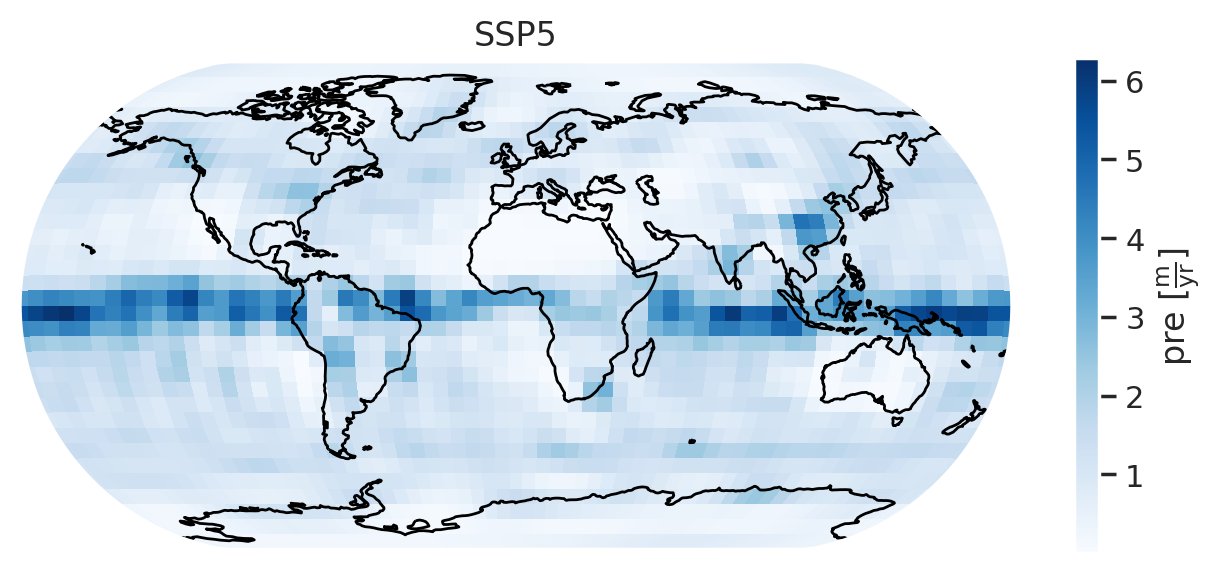

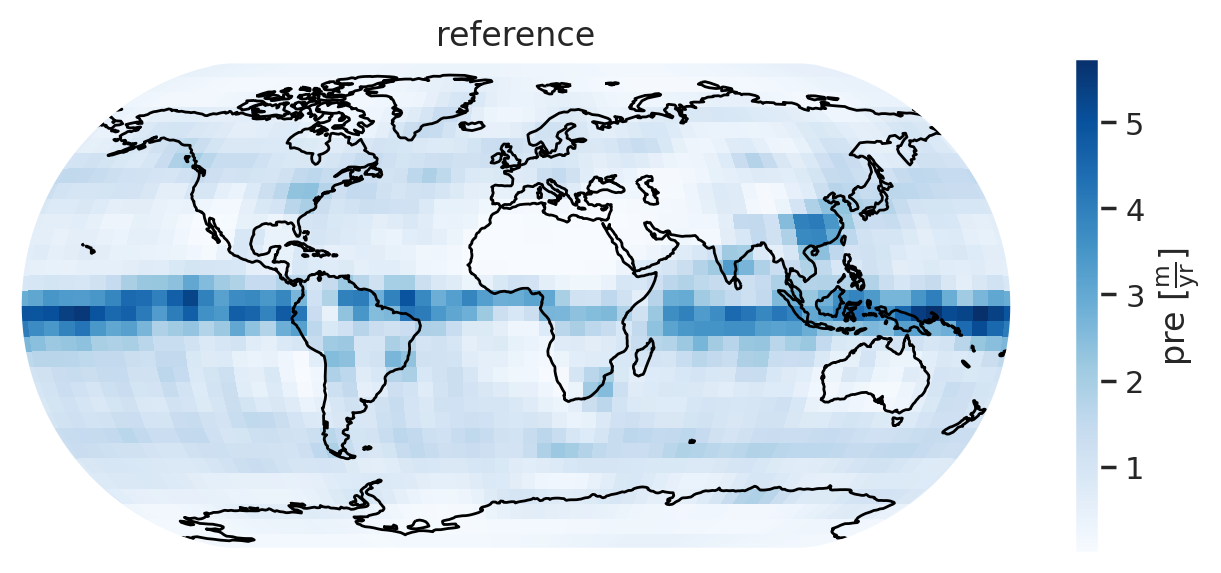

In [29]:
proj = ccrs.EckertIII()

for sce in list(pr_an_tm.keys()):
    fig, ax = plt.subplots(subplot_kw={"projection": proj})
    cm = ax.pcolormesh(xlon, ylat, pr_an_tm[sce], transform=trans, cmap="Blues")
    cb = fig.colorbar(cm, shrink=0.65)
    cb.set_label(r"pre [$\rm\frac{m}{yr}$]")
    ax.set_title(sce)
    ax.add_feature(cfeature.COASTLINE)

## Aridity index

From [New gridded maps of Koeppen's climate classification](https://www.researchgate.net/publication/255039317_New_gridded_maps_of_Koeppen%27s_climate_classification):

*Aridity indices provide a simple way to express the ratio of precipitation to
evaporation. Since evaporation is rarely observed it is a common tradition to
approximate it. In the approximation by De Martonne evaporation is set to mean
annual temperature $T_A$ in $°C$ $+10$.*

*The **aridity index of De Martonne** $AI_{dM}$ is
therefore defined as the ratio of the annual precipitation sum $P_A$ in mm and the
annual mean temperature $T_A$ in $°C$ $+10$. It is obvious that one disadvantage of this
definition is that the equation has a pole at $–10°C$ where the index is undefined.
Lower temperatures lead automatically to negative indices. One may argue that
the whole concept of aridity/humidity may not make much sense in cold regions.
However, since we draw global maps we have to deal with this problem. In order
to use the index world wide we define* 

$AI_{dM} = 100$ if $T_A < -9.9°C$ and $A_M = \frac{P_A}{T_A + 10}$ else.

*Note that the higher this coefficient is, the higher is the precipitation compared to
evaporation and thus the less arid is the climate. This means that by definition a
high aridity index means a humid climate while a low aridity index means an arid climate.*

From [Validation of temperature–precipitation based aridity index: Paleoclimatic implications](https://www.sciencedirect.com/science/article/pii/S0031018213002320#bb0125):

$AI_{dM}$ < 5: arid; 5–10: semi-arid; 10–20: semi-humid; 20–30: humid; > 30: perhumid

In [88]:
# import data
ai_pr = {}
ai_t2m = {}

# get values
for key, sce in zip(["reference", "SSP5"], ["plasim_ref_ln", "SSP5"]):
    # precipitation in m/s
    fpr = Dataset(f"../data/ai-{sce}-pre.nc")
    ai_pr[key] = fpr.variables["topo"][:]
    # surface temperature in K
    ft2m = Dataset(f"../data/ai-{sce}-tmp.nc")
    ai_t2m[key] = ft2m.variables["topo"][:]

lon = fpr.variables["lon"][:]
lat = fpr.variables["lat"][:]

fpr.close()
ft2m.close()

np.shape(ai_pr["reference"])

(32, 64)

In [99]:
# compute aridity index
ai = {}

for sce in ["reference", "SSP5"]:
    
    tai = np.ma.zeros((32, 64))
    tpr = ai_pr[sce] 
    tt2m = ai_t2m[sce] 
    
    # for every grid cell
    for la, _ in enumerate(lat):
        for lo, _ in enumerate(lon):
            # set to 100 if temperate is -10°C or below
            if tt2m[la,lo]-273.15 < -9.9:
                tai[la,lo] = 100
            # compute aridity index
            else:
                tai[la,lo] = tpr[la,lo] * 864e5 / (tt2m[la,lo]-273.15 + 10)

    ai[sce] = tai
    # keep sea mask!
    ai[sce].mask = tpr.mask

### Moisture regime maps

In [127]:
# colorbar setup
cmap = mpl.cm.get_cmap("summer_r").copy()

levels = [0, 5, 20, 30]

norm = mpl.colors.BoundaryNorm(levels, ncolors=cmap.N, extend="max")

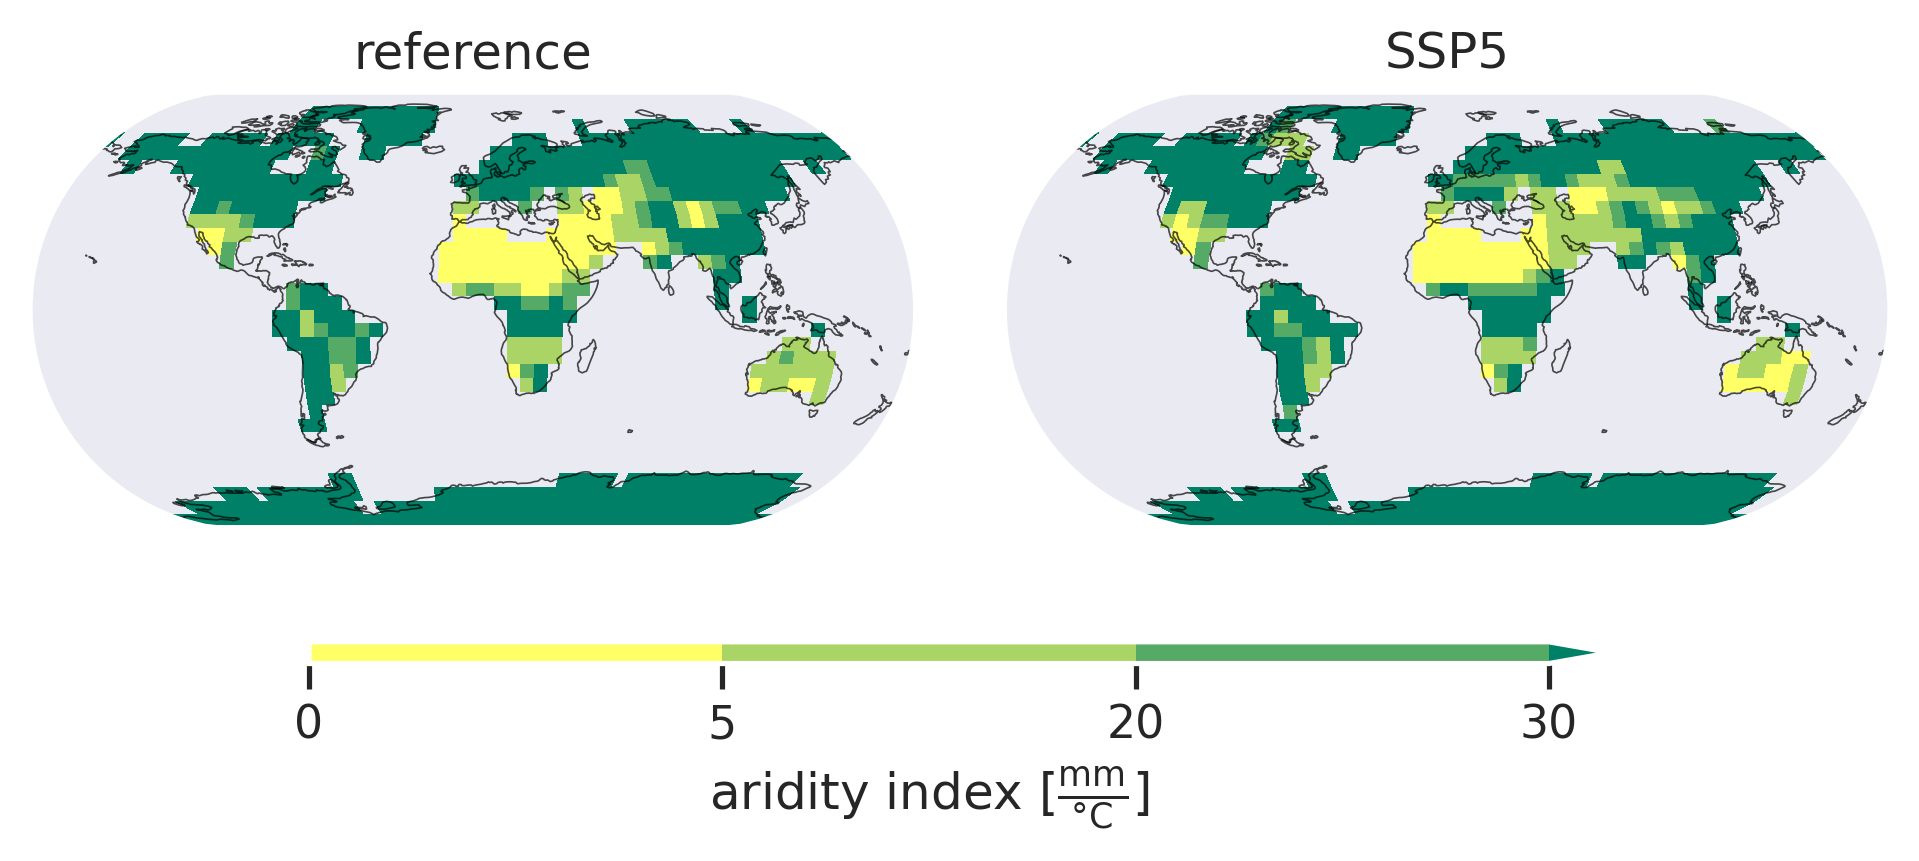

In [128]:
proj = ccrs.EckertIII()

fig, axs = plt.subplots(1, 2, dpi=150, sharex=True, sharey=True, gridspec_kw=dict(wspace = 0.1), subplot_kw=dict(projection = proj))
axs = axs.flatten()

for i, sce in enumerate(["reference", "SSP5"]):
    pai, _ = add_cyclic_point(ai[sce], coord=lon)
    cf = axs[i].pcolormesh(xllon, yllat, pai, transform=trans, cmap=cmap, norm=norm)
    #cf = axs[i].contourf(xllon, yllat, pai, transform=trans, levels=levels, extend="max", cmap=cmap)
    axs[i].set_title(sce)
    axs[i].coastlines(lw=0.4, alpha=0.7)
    #axs[i].set_facecolor("white")
    
cb = fig.colorbar(cf, ax=axs.tolist(), orientation="horizontal", shrink=0.7, aspect=60, pad=0.1)
cb.set_label(r"aridity index [$\rm\frac{mm}{°C}$]")

# TODO: add dry, moderate, humid, perhumid labels

**Note**: Quite reasonable result in comparison to [literature](https://www.researchgate.net/publication/255039317_New_gridded_maps_of_Koeppen%27s_climate_classification).

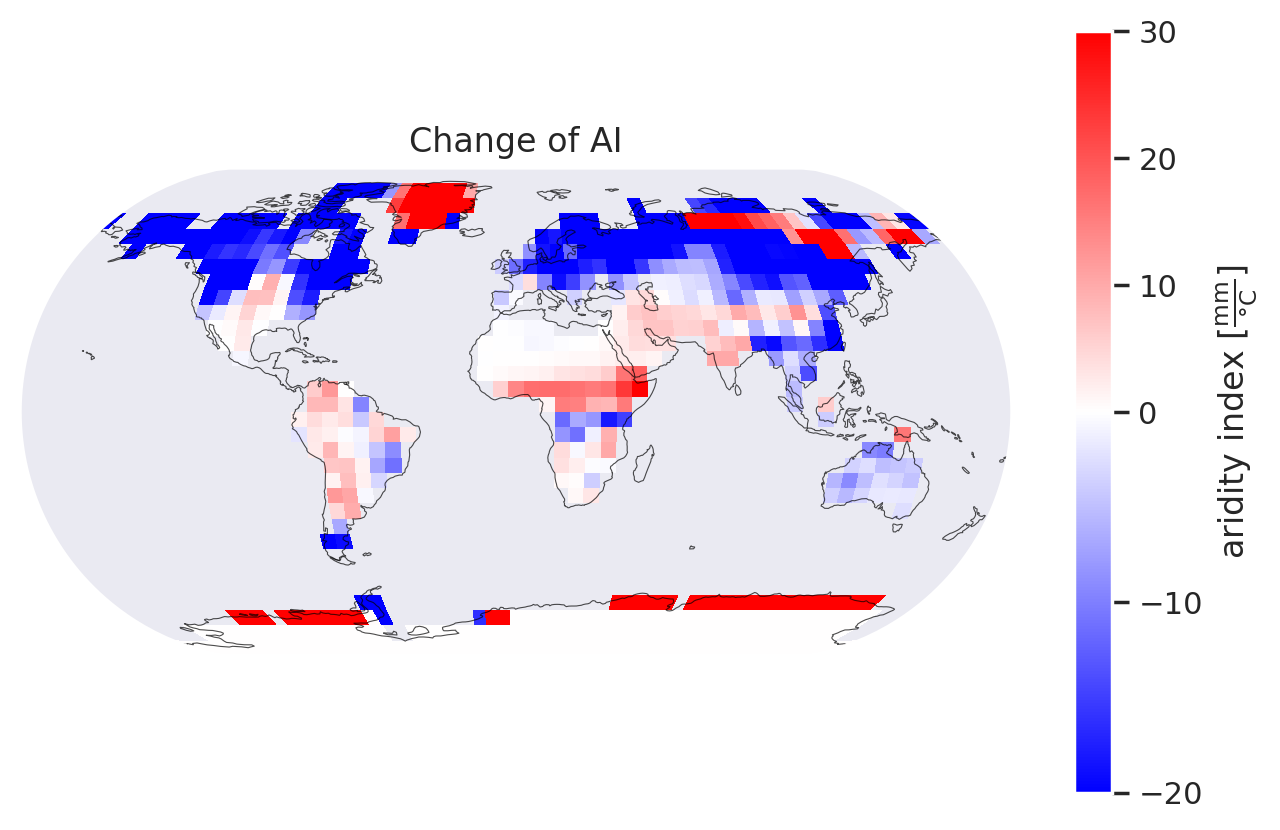

In [136]:
# TODO: investigate change & think about method to visualize!

ai_anom = ai["SSP5"] - ai["reference"]
pai_anom, _ = add_cyclic_point(ai_anom, coord=lon)

proj = ccrs.EckertIII()

fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection = proj))

cf = ax.pcolormesh(xllon, yllat, pai_anom, transform=trans, cmap="bwr", norm=mpl.colors.TwoSlopeNorm(vcenter=0, vmin=-20, vmax=30))
#cf = axs[i].contourf(xllon, yllat, pai, transform=trans, levels=levels, extend="both", cmap=cmap)
ax.set_title("Change of AI")
ax.coastlines(lw=0.4, alpha=0.7)
#axs[i].set_facecolor("white")
    
cb = fig.colorbar(cf)
cb.set_label(r"aridity index [$\rm\frac{mm}{°C}$]")